# Libraries

In [32]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.5

Found existing installation: tensorflow 2.5.0
Uninstalling tensorflow-2.5.0:
  Successfully uninstalled tensorflow-2.5.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.5.0-cp37-cp37m-manylinux2010_x86_64.whl (454.3 MB)
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
jaxlib 0.3.22+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jax 0.3.23 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
cupy-cuda11x 11.0.0 requi

In [33]:
!pip install --force-reinstall numpy==1.18.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.18.5-cp37-cp37m-manylinux1_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.18.5 which is incompatible.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.18.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
plotnine 0.8.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
jaxlib 0.3.22+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
jax 0.3.23 requires numpy>=1.20, but you have 

In [34]:
%tensorflow_version 2.5
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.5.0


In [35]:
%reset
import re
import scipy
import seaborn as sns
import time
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #Disables warning
from tensorflow import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
### Set Seeds ###
seed_value = np.uint64(np.random.randint(0,2147483647))
seed_value = np.uint64(340733825)
print("Using seeds: ",seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
random.set_seed(seed_value)

Using seeds:  340733825


# Dataset Handling

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
train_dataset = pd.read_csv('/content/drive/MyDrive/Corona_NLP_train.csv' , encoding = 'latin-1')
test_dataset = pd.read_csv('/content/drive/MyDrive/Corona_NLP_test.csv', encoding = 'latin-1')

print('Train dataset: {}'.format(len(train_dataset)))
print('Test dataset: {}'.format(len(test_dataset)))

Train dataset: 41157
Test dataset: 3798


In [39]:
train_dataset.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [40]:
### Check missing and unique values ###
train_dataset.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

# Data Pre-processing

In [41]:
X = train_dataset['OriginalTweet'].copy()
y = train_dataset['Sentiment'].copy()

def tweet_cleaner(tweet):

    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # remove numbers
    tweet = re.sub(r'\d+',' ', tweet)
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    # remove stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet

stop_words = stopwords.words('english')
X_new = X.apply(tweet_cleaner)
X_new.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_new)

X = tokenizer.texts_to_sequences(X_new)

vocabulary_size = len(tokenizer.word_index) + 1

print(f'Vocabulary Size: {vocabulary_size}\n')
print(f'Case1 - Sentence:\n{X_new[10]}\n')
print(f'After Tokenizing:\n{X[10]}\n')

X = pad_sequences(X, padding='post')
print("After padding :\n{}".format(X[10]))

Vocabulary Size: 36117

Case1 - Sentence:
All month crowding supermarkets restaurants, however reducing hours closing malls means everyone using entrance dependent single supermarket.

After Tokenizing:
[118, 372, 3809, 179, 408, 803, 1613, 194, 613, 2149, 501, 77, 272, 2903, 4690, 723, 6]

After padding :
[ 118  372 3809  179  408  803 1613  194  613 2149  501   77  272 2903
 4690  723    6    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [43]:
ord_encoded = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative',
          'Neutral',
          'Positive']
           
y.replace(ord_encoded, inplace=True)

# Model Architecture

In [44]:
### Hyper Parameters ###
epochs = 2
batch_size = 32
embedding_dimension = 16
units = 256
validation_split = 0.12
verbose = 1

In [45]:
%%time
import tensorflow as tf
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    Layer.Embedding(vocabulary_size, embedding_dimension, input_length=X.shape[1]),
    Layer.Bidirectional(Layer.LSTM(units,return_sequences=True)),
    Layer.GlobalMaxPool1D(),
    Layer.Dropout(0.4),
    Layer.Dense(64, activation="relu"),
    Layer.Dropout(0.4),
    Layer.Dense(3)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 16)            577872    
_________________________________________________________________
bidirectional (Bidirectional (None, 54, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [46]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [47]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [48]:
%%time
history = model.fit(X, y, 
          epochs=epochs, 
          validation_split=validation_split,
          verbose=verbose,
          batch_size=batch_size,
          callbacks=callbacks)

Epoch 1/2
1132/1132 [==============================] - 35s 29ms/step - loss: 0.6687 - accuracy: 0.7106 - val_loss: 0.3918 - val_accuracy: 0.8670
Epoch 2/2
1132/1132 [==============================] - 19s 17ms/step - loss: 0.3401 - accuracy: 0.8893 - val_loss: 0.3554 - val_accuracy: 0.8826
CPU times: user 53.8 s, sys: 3.84 s, total: 57.7 s
Wall time: 1min 24s


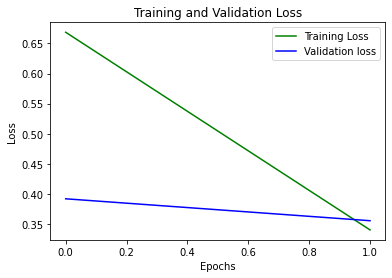

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'g', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

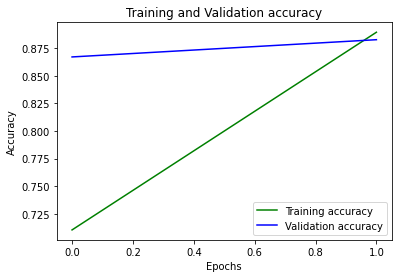

In [50]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [51]:
X_test = test_dataset['OriginalTweet'].copy()
y_test = test_dataset['Sentiment'].copy()

X_test = X_test.apply(tweet_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post')

y_test.replace(ord_encoded, inplace=True)

In [52]:
y_pred = model.predict_classes(X_test)

score = model.evaluate(X_test, y_test, verbose = 0, batch_size = batch_size)
print()

print("ACCURACY: ", score[1])
print("LOSS: ", score[0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



ACCURACY:  0.853607177734375
LOSS:  0.41723474860191345


In [53]:
model.save('best_model.h5')

In [54]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85      1633
     Neutral       0.89      0.78      0.83       619
    Positive       0.83      0.90      0.86      1546

    accuracy                           0.85      3798
   macro avg       0.86      0.84      0.85      3798
weighted avg       0.86      0.85      0.85      3798



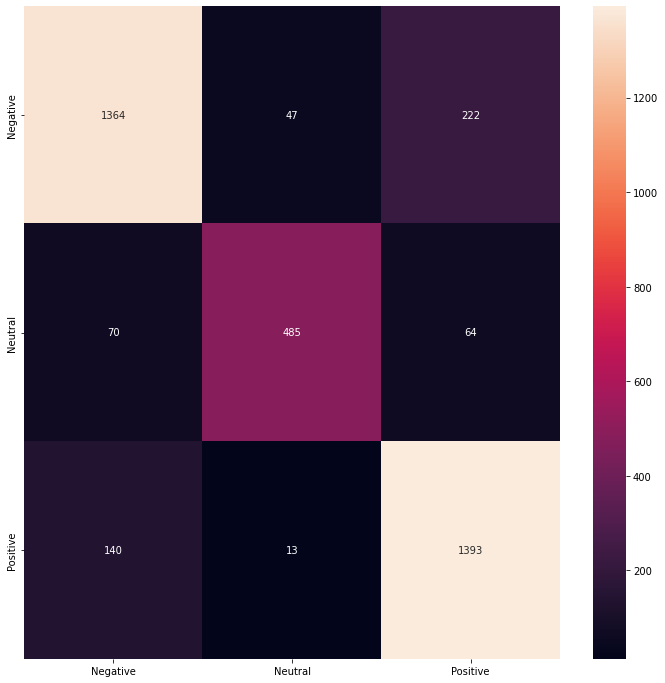

In [55]:
conf_mat = confusion_matrix(y_test, y_pred)

cm = pd.DataFrame(
    conf_mat, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,12))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# Prediction examples

In [56]:
max_length = 350
### Predict if tweet is positive or negative ###
def predict_sentiment(input):
    tweet = input
    tweet_sequences = tokenizer.texts_to_sequences(tweet)
    # Padded Sequence
    padded = pad_sequences(tweet_sequences, padding='post', maxlen=max_length)
    # Obtain based on probability 1 if probability >= 0.5 else 0
    prediction = model.predict_classes(padded)
    pred_labels = []
    for i in prediction:
        if i >= 0.5:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    for i in range(len(tweet)):
        print(tweet[i])
        if pred_labels[i] == 1:
            s = 'Positive'
        elif pred_labels[i] == 0:
            s = 'Negative'
        else:
            s = 'Neutral'
        print("Predicted sentiment : ",s)

In [57]:
predict_sentiment(["Covid brings catastrophic effect on your body", 
                   "It would better to stay away from Covid",
                   "Not going outside is a must",
                   "We dont want people to be coughing outside",
                   "Always wear your mask outside"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Covid brings catastrophic effect on your body
Predicted sentiment :  Positive
It would better to stay away from Covid
Predicted sentiment :  Positive
Not going outside is a must
Predicted sentiment :  Positive
We dont want people to be coughing outside
Predicted sentiment :  Positive
Always wear your mask outside
Predicted sentiment :  Positive


# Hyper-Parameter Tuning for 2 max trials with 2 epochs

In [61]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 30.8 MB/s 
     |████████████████████████████████| 1.6 MB 46.7 MB/s 


In [63]:
%%time
#2 epoch con 2 max_trials
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPool1D


def build_model(hyperparameter):
    model = Sequential()
    hp_units1 = hyperparameter.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hyperparameter.Int('units2', min_value=32, max_value=512, step=32)
    model.add(Embedding(vocabulary_size, embedding_dimension, input_length = X.shape[1]))
    model.add(Bidirectional(LSTM(units = hp_units1,return_sequences=True))) #model.add(Bidirectional(LSTM(units = hp.Int(units, min_value = 32, max_value = 512, step = 32),return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.4))
    model.add(Dense(units = hp_units2, activation = 'relu')) #model.add(Dense(units = hp.Int(64, min_value = 32, max_value = 512, step = 32), activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3))

    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], 
                  optimizer=Adam(hyperparameter.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])))

    return model

bayesian_optimizer_tuner = BayesianOptimization(build_model,
                                                objective='accuracy',
                                                max_trials=2,
                                                executions_per_trial=1,
                                                directory=os.path.normpath(''),
                                                project_name = 'sentiment_analysis_covid19_tweets',
                                                overwrite=True)

EVALUATION_INTERVAL = 200
EPOCHS = 2
stop_early = EarlyStopping(monitor='val_loss', patience=5) #min_delta=1e-4, patience=5

bayesian_optimizer_tuner.search(X, y,
                               epochs=EPOCHS,
                               validation_data=(X_test, y_test),
                               validation_steps=50,
                               validation_split=1.2,
                               steps_per_epoch=EVALUATION_INTERVAL,
                               callbacks=[stop_early]
                               #verbose=1
                               )

bayes_opt_model_best_model = bayesian_optimizer_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model

Trial 2 Complete [00h 00m 23s]
accuracy: 0.4630523920059204

Best accuracy So Far: 0.8924221992492676
Total elapsed time: 00h 00m 34s
CPU times: user 27.2 s, sys: 1.84 s, total: 29 s
Wall time: 35.5 s


In [64]:
bayesian_optimizer_tuner.search_space_summary()

Search space summary
Default search space size: 3
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [65]:
bayesian_optimizer_tuner.results_summary()

Results summary
Results in ./sentiment_analysis_covid19_tweets
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 32
units2: 32
learning_rate: 0.01
Score: 0.8924221992492676
Trial summary
Hyperparameters:
units1: 256
units2: 64
learning_rate: 0.0001
Score: 0.4630523920059204


In [66]:
best_model = model[0]
best_model.fit(X, y)

1287/1287 [==============================] - 20s 14ms/step - loss: 0.3615 - accuracy: 0.8863


In [67]:
best_model.save("best_model2.h5")